## Task 1

In [3]:
from melbanks import LogMelFilterBanks
import torchaudio
import torch


signal, sr = torchaudio.load("ezyZip.wav")
#signal = dataset[0][0]
melspec = torchaudio.transforms.MelSpectrogram(
    hop_length=160,
    n_mels=80
)(signal)
logmelbanks = LogMelFilterBanks()(signal)

assert torch.log(melspec + 1e-6).shape == logmelbanks.shape
assert torch.allclose(torch.log(melspec + 1e-6), logmelbanks)

wav shapes:  torch.Size([2, 479729])
Spectrogram shape: torch.Size([2, 201, 2999])
Mel filterbanks shape: torch.Size([201, 80])
Spectrogram shape: torch.Size([2, 201, 2999])


In [4]:
print(logmelbanks)
print(torch.log(melspec + 1e-6))

tensor([[[-13.8155,  -5.3166,  -2.2109,  ...,  -7.8052,  -8.3567, -12.8381],
         [-13.8155,  -4.0303,  -0.9245,  ...,  -6.5205,  -7.0733, -11.8695],
         [-13.8155,  -4.0358,  -1.1171,  ...,  -6.3517,  -6.7032, -10.0962],
         ...,
         [-13.8155, -13.6870, -13.0101,  ..., -13.7074, -13.6397, -13.7750],
         [-13.8155, -13.7313, -13.1908,  ..., -13.7311, -13.6358, -13.7288],
         [-13.8155, -13.7645, -13.3459,  ..., -13.7481, -13.7027, -13.7004]],

        [[-13.8155,  -5.2662,  -2.1626,  ..., -12.1977,  -8.6658, -10.1273],
         [-13.8155,  -3.9798,  -0.8761,  ..., -11.0662,  -7.3836,  -8.8591],
         [-13.8155,  -3.9869,  -1.0691,  ...,  -6.9062,  -8.1100,  -8.6181],
         ...,
         [-13.8155, -13.6813, -12.9052,  ..., -13.5859, -13.6149, -13.7316],
         [-13.8155, -13.7345, -13.1898,  ..., -13.7326, -13.7371, -13.6934],
         [-13.8155, -13.7639, -13.5534,  ..., -13.7604, -13.7296, -13.7048]]])
tensor([[[-13.8155,  -5.3166,  -2.2109,  ...

## Task 2

### Dataset preproc

In [1]:
from torchaudio.datasets import SPEECHCOMMANDS
import os
from torch import Tensor
from typing import Tuple
import torchaudio

class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]

        self._walker = [w for w in self._walker if os.path.basename(os.path.dirname(w)).lower() in ["yes", "no"]]

    def __getitem__(self, n: int) -> Tuple[Tensor, int]:
        waveform, _, label, _, _ = super().__getitem__(n)
        binary_label = 1 if label.lower() == "yes" else 0

        return waveform, binary_label

train_set = SubsetSC("training")
test_set = SubsetSC("testing")
val_set = SubsetSC("validation")

waveform, label = train_set[0]
print("Waveform: ", waveform)
print("label: ", label)

Waveform:  tensor([[0.0072, 0.0061, 0.0055,  ..., 0.0098, 0.0085, 0.0092]])
label:  0


In [ ]:
# check labels
labels = sorted(list(set(datapoint[1] for datapoint in train_set)))
labels

[0, 1]

In [3]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=16000, new_freq=new_sample_rate)
transformed = transform(waveform)

In [4]:
import torch

def pad_sequence(batch):
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):
    tensors, targets = [], []

    for waveform, label in batch:
        tensors += [waveform]
        targets += [Tensor([label])]

    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

device = "cuda"

num_workers = 1
pin_memory = True

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

### Model architecture

In [5]:
#!pip install ptflops

In [6]:
from torch import nn
import torch.nn.functional as F
from ptflops import get_model_complexity_info
from melbanks import LogMelFilterBanks


class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32, n_mels=80, groups=1):
        super().__init__()
        self.logmel = LogMelFilterBanks(n_mels=n_mels)
        self.conv1 = nn.Conv1d(n_mels, n_channel, kernel_size=3, padding=1, groups=groups)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3, groups=groups)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(2)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3, groups=groups)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(2)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3, groups=groups)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(2)
        self.fc1 = nn.Linear(2 * n_channel, 1)

    def forward(self, x):
        x = self.logmel(x)
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return x

    def compute_flops(self, input_size):
        macs, params = get_model_complexity_info(self, input_size, as_strings=True, print_per_layer_stat=False)
        return macs, params


model = M5(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)
flops, params_str = model.compute_flops((1, 16000))
print("FLOPs:", flops, "Params:", params_str)

M5(
  (logmel): LogMelFilterBanks()
  (conv1): Conv1d(80, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_fea

In [7]:
transformed.shape

torch.Size([1, 8000])

In [7]:
from tqdm import tqdm

def train(model, train_loader, optimizer, device="cuda"):
    model.train()
    loss_fn = nn.BCEWithLogitsLoss()
    running_loss = .0
    for input, target in tqdm(train_loader, desc="Train"):
        input = input.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(input)
        loss = loss_fn(output.squeeze(1), target.float())
        running_loss += loss.item() * input.size(0)
        loss.backward()
        optimizer.step()
    avg_loss =  running_loss / len(train_loader.dataset)
    return avg_loss

In [8]:
def validate(model, val_loader, device="cuda"):
    model.eval()
    loss_fn = nn.BCEWithLogitsLoss()
    running_loss = .0
    cor_preds = 0
    with torch.no_grad():
        for input, target in tqdm(val_loader, desc="Eval"):
            input = input.to(device)
            target = target.to(device)
            output = model(input)
            loss = loss_fn(output.squeeze(1), target.float())
            running_loss += loss.item() * input.size(0)
            preds = torch.sigmoid(output.squeeze(1)) >= 0.5
            cor_preds += (preds == target).sum().item()
    avg_loss = running_loss / len(val_loader.dataset)
    accuracy = cor_preds / len(val_loader.dataset)
    return avg_loss, accuracy

In [9]:
def test(model, test_loader, device="cuda"):
    model.eval()
    cor_preds = 0
    with torch.no_grad():
        for input, target in tqdm(test_loader, desc="Test"):
            input = input.to(device)
            target = target.to(device)
            outputs = model(input)
            preds = torch.sigmoid(outputs.squeeze(1)) >= 0.5
            cor_preds += (preds == target).sum().item()
    accuracy = cor_preds / len(test_loader.dataset)
    return accuracy

In [15]:
import time

import torch
torch.manual_seed(0)

def run_train(n_mels, groups=1, epochs=10):
    model = M5(n_input=transformed.shape[0], n_output=len(labels), n_mels=n_mels, groups=groups)
    model.to(device)

    n = count_parameters(model)
    print("Number of parameters: %s" % n)
    flops, params_str = model.compute_flops((1, 16000))
    print("FLOPs:", flops, "Params:", params_str)

    from torch import optim
    optimizer = optim.Adam(model.parameters(), lr=0.003, weight_decay=0.0001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

    train_hist = {
        "train_loss": []
    }
    val_hist = {
        "val_loss": [],
        "val_acc": []
    }
    epoch_times = []
    for epoch in range(1, epochs + 1):
        start = time.time()
        train_loss = train(model, train_loader, optimizer)
        epoch_times.append(time.time() - start)
        val_loss, val_acc = validate(model, val_loader)

        train_hist["train_loss"].append(train_loss)
        val_hist["val_loss"].append(val_loss)
        val_hist["val_acc"].append(val_acc)

        print(f"Epoch - {epoch}/{epochs} - Train Loss: {train_loss} - Val Loss: {val_loss} - Val Acc.: {val_acc}")

    avg_epoch_time = sum(epoch_times) / len(epoch_times)
    test_acc = test(model, test_loader)
    print(f"Test Acc.: {test_acc}")

    return {
        "model": model,
        "train_hist": train_hist,
        "val_hist": val_hist,
        "test_acc": test_acc,
        "n_mels": n_mels,
        "n_params": n,
        "flops": flops,
        "avg_epoch_time": avg_epoch_time,
        "groups": groups
    }

In [ ]:
exp_1 = run_train(20)

Number of parameters: 24065
FLOPs: 1.03 MMac Params: 24.07 k


Eval: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


Epoch - 1/10 - Train Loss: 0.22877863496916967 - Val Loss: 0.13116751047104114 - Val Acc.: 0.9713574097135741


Eval: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]


Epoch - 2/10 - Train Loss: 0.09193936465281703 - Val Loss: 0.09509703135848564 - Val Acc.: 0.9539227895392279


Eval: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


Epoch - 3/10 - Train Loss: 0.06050841726852536 - Val Loss: 0.04164566529235092 - Val Acc.: 0.9900373599003736


Eval: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


Epoch - 4/10 - Train Loss: 0.03980953576814907 - Val Loss: 0.05786045431014461 - Val Acc.: 0.9813200498132005


Eval: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


Epoch - 5/10 - Train Loss: 0.03186584100685018 - Val Loss: 0.05367207857704771 - Val Acc.: 0.9825653798256538


Eval: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


Epoch - 6/10 - Train Loss: 0.028656283097611767 - Val Loss: 0.06990799710782568 - Val Acc.: 0.975093399750934


Eval: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


Epoch - 7/10 - Train Loss: 0.02491361582924188 - Val Loss: 0.048260711370080075 - Val Acc.: 0.9763387297633873


Eval: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


Epoch - 8/10 - Train Loss: 0.02252377706370983 - Val Loss: 0.03308650317072989 - Val Acc.: 0.987546699875467


Eval: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


Epoch - 9/10 - Train Loss: 0.017056398515564047 - Val Loss: 0.03436094596239728 - Val Acc.: 0.987546699875467


Eval: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


Epoch - 10/10 - Train Loss: 0.01877720940233533 - Val Loss: 0.04437628235915997 - Val Acc.: 0.9825653798256538


Test: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]

Test Acc.: 0.9842233009708737


In [17]:
exp_2 = run_train(40)

Number of parameters: 25985
FLOPs: 1.63 MMac Params: 25.98 k


Eval: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


Epoch - 1/10 - Train Loss: 0.21424884899405422 - Val Loss: 0.10819872876960937 - Val Acc.: 0.975093399750934


Eval: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


Epoch - 2/10 - Train Loss: 0.08159658694232587 - Val Loss: 0.08371914281123602 - Val Acc.: 0.9813200498132005


Eval: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


Epoch - 3/10 - Train Loss: 0.06000226074563103 - Val Loss: 0.0591567907746821 - Val Acc.: 0.9825653798256538


Eval: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


Epoch - 4/10 - Train Loss: 0.04459466481919407 - Val Loss: 0.05551245723123828 - Val Acc.: 0.9800747198007472


Eval: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


Epoch - 5/10 - Train Loss: 0.03840089074683737 - Val Loss: 0.067534629635369 - Val Acc.: 0.9788293897882939


Eval: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


Epoch - 6/10 - Train Loss: 0.03326211601833234 - Val Loss: 0.055562340652113164 - Val Acc.: 0.9825653798256538


Eval: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


Epoch - 7/10 - Train Loss: 0.029999232563574233 - Val Loss: 0.07636328881700984 - Val Acc.: 0.9713574097135741


Eval: 100%|██████████| 4/4 [00:03<00:00,  1.14it/s]


Epoch - 8/10 - Train Loss: 0.030587515541501447 - Val Loss: 0.03880219406924984 - Val Acc.: 0.9850560398505604


Eval: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]


Epoch - 9/10 - Train Loss: 0.023518176097217767 - Val Loss: 0.038090314264936954 - Val Acc.: 0.987546699875467


Eval: 100%|██████████| 4/4 [00:03<00:00,  1.22it/s]


Epoch - 10/10 - Train Loss: 0.020384273703610532 - Val Loss: 0.03597733531968383 - Val Acc.: 0.987546699875467


Test: 100%|██████████| 4/4 [00:03<00:00,  1.10it/s]

Test Acc.: 0.9854368932038835


In [18]:
exp_3 = run_train(80)

Number of parameters: 29825
FLOPs: 2.83 MMac Params: 29.82 k


Eval: 100%|██████████| 4/4 [00:03<00:00,  1.14it/s]


Epoch - 1/10 - Train Loss: 0.22345491548394886 - Val Loss: 0.10471234961434883 - Val Acc.: 0.9613947696139477


Eval: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Epoch - 2/10 - Train Loss: 0.07813640386123971 - Val Loss: 0.07788322273999045 - Val Acc.: 0.9676214196762142


Eval: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


Epoch - 3/10 - Train Loss: 0.05179951576555289 - Val Loss: 0.0701929963139323 - Val Acc.: 0.9726027397260274


Eval: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]


Epoch - 4/10 - Train Loss: 0.045003425100242314 - Val Loss: 0.05371614158673126 - Val Acc.: 0.9825653798256538


Eval: 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]


Epoch - 5/10 - Train Loss: 0.04257201722706778 - Val Loss: 0.08140795616430704 - Val Acc.: 0.9738480697384807


Eval: 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]


Epoch - 6/10 - Train Loss: 0.0386845622089823 - Val Loss: 0.05403345302420008 - Val Acc.: 0.9800747198007472


Eval: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


Epoch - 7/10 - Train Loss: 0.029234161281143204 - Val Loss: 0.1350196167576715 - Val Acc.: 0.9551681195516812


Eval: 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]


Epoch - 8/10 - Train Loss: 0.026559250761490266 - Val Loss: 0.03671130524996951 - Val Acc.: 0.9925280199252802


Eval: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


Epoch - 9/10 - Train Loss: 0.023802110314200455 - Val Loss: 0.036038254365060536 - Val Acc.: 0.987546699875467


Eval: 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]


Epoch - 10/10 - Train Loss: 0.02472470793550815 - Val Loss: 0.04588264100494821 - Val Acc.: 0.9825653798256538


Test: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]

Test Acc.: 0.9830097087378641


In [33]:
exp_1

{'model': M5(
   (logmel): LogMelFilterBanks()
   (conv1): Conv1d(20, 32, kernel_size=(3,), stride=(1,), padding=(1,))
   (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
   (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
   (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
   (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (pool4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

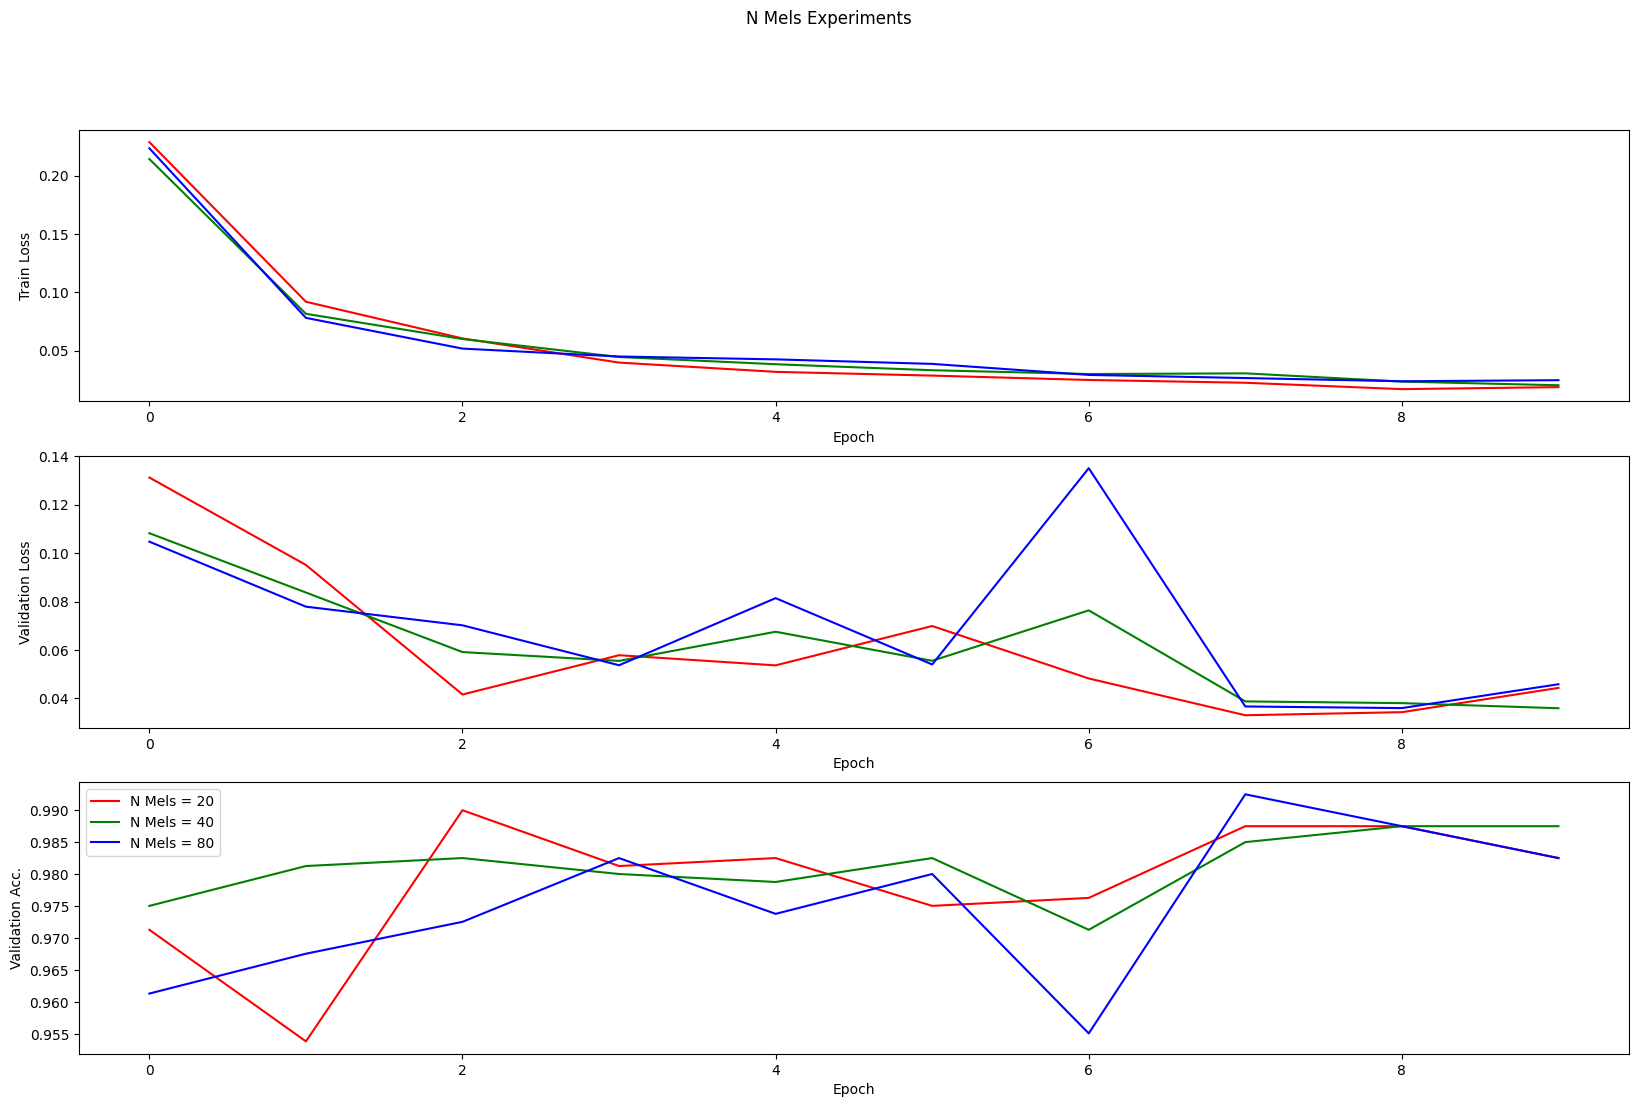

In [23]:
import matplotlib.pyplot as plt

#plt.figure(figsize=(20, 12), dpi=80)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 12))
fig.suptitle("N Mels Experiments")

mels2color = {
    20: "r",
    40: "g",
    80: "b"
}

for exp in [exp_1, exp_2, exp_3]:
    n_mels = exp["n_mels"]
    ax1.plot(list(range(10)), exp["train_hist"]["train_loss"], mels2color[n_mels], label=f"N Mels = {n_mels}")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Train Loss")

for exp in [exp_1, exp_2, exp_3]:
    n_mels = exp["n_mels"]
    ax2.plot(list(range(10)), exp["val_hist"]["val_loss"], mels2color[n_mels], label=f"N Mels = {n_mels}")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Validation Loss")

for exp in [exp_1, exp_2, exp_3]:
    n_mels = exp["n_mels"]
    ax3.plot(list(range(10)), exp["val_hist"]["val_acc"], mels2color[n_mels], label=f"N Mels = {n_mels}")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Validation Acc.")



plt.legend()
plt.show()

Text(0.5, 1.0, 'N Mels vs Test Acc.')

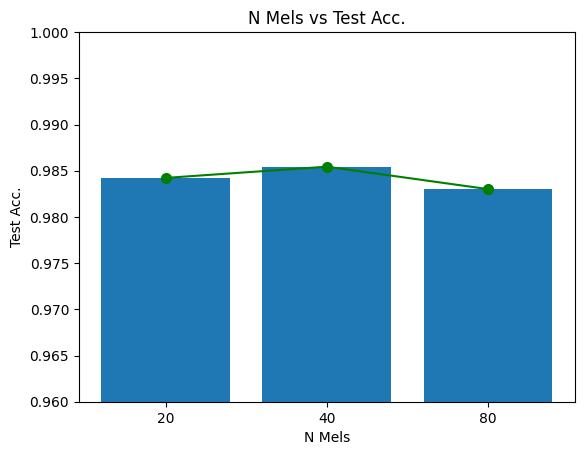

In [28]:
x = [str(exp["n_mels"]) for exp in [exp_1, exp_2, exp_3]]
y = [exp["test_acc"] for exp in [exp_1, exp_2, exp_3]]

plt.bar(x, y)
plt.plot(x, y, color='g', marker='o', markersize=7)
plt.ylim(0.96, 1)
plt.xlabel("N Mels")
plt.ylabel("Test Acc.")
plt.title("N Mels vs Test Acc.")

Text(0.5, 1.0, 'N Mels vs Avg. Epoch Time (sec.)')

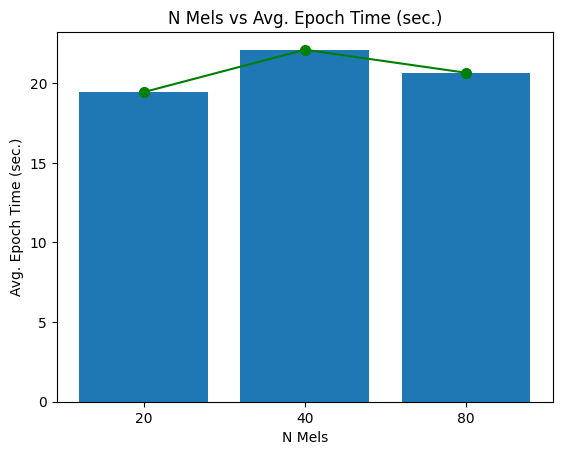

In [40]:
x = [str(exp["n_mels"]) for exp in [exp_1, exp_2, exp_3]]
y = [exp["avg_epoch_time"] for exp in [exp_1, exp_2, exp_3]]

plt.bar(x, y)
plt.plot(x, y, color='g', marker='o', markersize=7)
plt.xlabel("N Mels")
plt.ylabel("Avg. Epoch Time (sec.)")
plt.title("N Mels vs Avg. Epoch Time (sec.)")

In [29]:
exp_2_1 = run_train(40, 2)

Number of parameters: 13313
FLOPs: 1.24 MMac Params: 13.31 k


Eval: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


Epoch - 1/10 - Train Loss: 0.26518417032832203 - Val Loss: 0.17256167902150754 - Val Acc.: 0.962640099626401


Eval: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


Epoch - 2/10 - Train Loss: 0.09705890402240024 - Val Loss: 0.09537746745902827 - Val Acc.: 0.9638854296388543


Eval: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


Epoch - 3/10 - Train Loss: 0.05921432844410906 - Val Loss: 0.07013052294047023 - Val Acc.: 0.9701120797011208


Eval: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Epoch - 4/10 - Train Loss: 0.04563807252209754 - Val Loss: 0.05100519934745684 - Val Acc.: 0.9800747198007472


Eval: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


Epoch - 5/10 - Train Loss: 0.041987135856359326 - Val Loss: 0.047121635674131315 - Val Acc.: 0.9850560398505604


Eval: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


Epoch - 6/10 - Train Loss: 0.03462529479730763 - Val Loss: 0.09969622532055385 - Val Acc.: 0.962640099626401


Eval: 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]


Epoch - 7/10 - Train Loss: 0.029488351703458853 - Val Loss: 0.04079090897689758 - Val Acc.: 0.9813200498132005


Eval: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


Epoch - 8/10 - Train Loss: 0.02920290759374095 - Val Loss: 0.03137218910541993 - Val Acc.: 0.9925280199252802


Eval: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


Epoch - 9/10 - Train Loss: 0.022749057121647532 - Val Loss: 0.05450325221337081 - Val Acc.: 0.9825653798256538


Eval: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


Epoch - 10/10 - Train Loss: 0.020820866778642925 - Val Loss: 0.03150455555953967 - Val Acc.: 0.9887920298879203


Test: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]

Test Acc.: 0.9854368932038835


In [30]:
exp_2_2 = run_train(40, 4)

Number of parameters: 6977
FLOPs: 1.05 MMac Params: 6.98 k


Eval: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Epoch - 1/10 - Train Loss: 0.4062569831791221 - Val Loss: 0.35034715758165713 - Val Acc.: 0.8493150684931506


Eval: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


Epoch - 2/10 - Train Loss: 0.15596386689497038 - Val Loss: 0.13513316324497962 - Val Acc.: 0.958904109589041


Eval: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


Epoch - 3/10 - Train Loss: 0.08671190864698022 - Val Loss: 0.13233605348232524 - Val Acc.: 0.9464508094645081


Eval: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


Epoch - 4/10 - Train Loss: 0.06699439849248658 - Val Loss: 0.0632604928698813 - Val Acc.: 0.975093399750934


Eval: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


Epoch - 5/10 - Train Loss: 0.05583148858867077 - Val Loss: 0.05787362933975376 - Val Acc.: 0.975093399750934


Eval: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


Epoch - 6/10 - Train Loss: 0.048108868830588 - Val Loss: 0.05694975395910767 - Val Acc.: 0.9800747198007472


Eval: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


Epoch - 7/10 - Train Loss: 0.043828241652467785 - Val Loss: 0.07003332814143723 - Val Acc.: 0.9701120797011208


Eval: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


Epoch - 8/10 - Train Loss: 0.037963058811223666 - Val Loss: 0.05114688783197444 - Val Acc.: 0.9800747198007472


Eval: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


Epoch - 9/10 - Train Loss: 0.03342237563340328 - Val Loss: 0.09185958126296578 - Val Acc.: 0.9638854296388543


Eval: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


Epoch - 10/10 - Train Loss: 0.03494928696009115 - Val Loss: 0.05756474262193903 - Val Acc.: 0.9763387297633873


Test: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]

Test Acc.: 0.9696601941747572


In [31]:
exp_2_3 = run_train(40, 8)

Number of parameters: 3809
FLOPs: 950.5 KMac Params: 3.81 k


Eval: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


Epoch - 1/10 - Train Loss: 0.4369342728544609 - Val Loss: 0.37705357998127065 - Val Acc.: 0.8829389788293898


Eval: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


Epoch - 2/10 - Train Loss: 0.20927501397430615 - Val Loss: 0.16485766496783028 - Val Acc.: 0.937733499377335


Eval: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


Epoch - 3/10 - Train Loss: 0.13988593878349292 - Val Loss: 0.12484940490308467 - Val Acc.: 0.958904109589041


Eval: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


Epoch - 4/10 - Train Loss: 0.11248141416085145 - Val Loss: 0.1042954539729382 - Val Acc.: 0.9713574097135741


Eval: 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]


Epoch - 5/10 - Train Loss: 0.0900587641680042 - Val Loss: 0.09199266074454948 - Val Acc.: 0.9726027397260274


Eval: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


Epoch - 6/10 - Train Loss: 0.08084242287982218 - Val Loss: 0.10278560565888956 - Val Acc.: 0.9601494396014943


Eval: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


Epoch - 7/10 - Train Loss: 0.06878845989891627 - Val Loss: 0.08632177493974548 - Val Acc.: 0.9713574097135741


Eval: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


Epoch - 8/10 - Train Loss: 0.061341254580232776 - Val Loss: 0.07421429158834414 - Val Acc.: 0.9726027397260274


Eval: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]


Epoch - 9/10 - Train Loss: 0.0553716131670271 - Val Loss: 0.07455522188009836 - Val Acc.: 0.9701120797011208


Eval: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


Epoch - 10/10 - Train Loss: 0.05560364717627592 - Val Loss: 0.06903056043709349 - Val Acc.: 0.9763387297633873


Test: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]

Test Acc.: 0.9696601941747572


In [ ]:
#exp_2_4 = run_train(40, 16)

ValueError: in_channels must be divisible by groups

Text(0.5, 1.0, 'Conv Group vs Avg. Epoch Time (sec.)')

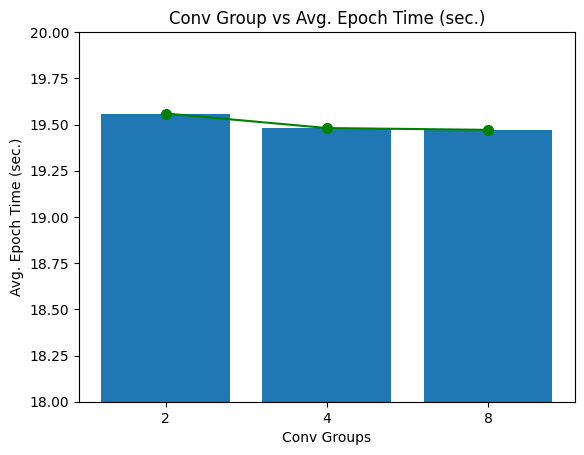

In [35]:
x = [str(exp["groups"]) for exp in [exp_2_1, exp_2_2, exp_2_3]]
y = [exp["avg_epoch_time"] for exp in [exp_2_1, exp_2_2, exp_2_3]]

plt.bar(x, y)
plt.plot(x, y, color='g', marker='o', markersize=7)
plt.ylim(18, 20)
plt.xlabel("Conv Groups")
plt.ylabel("Avg. Epoch Time (sec.)")
plt.title("Conv Group vs Avg. Epoch Time (sec.)")

Text(0.5, 1.0, 'Conv Group vs Number of Params.')

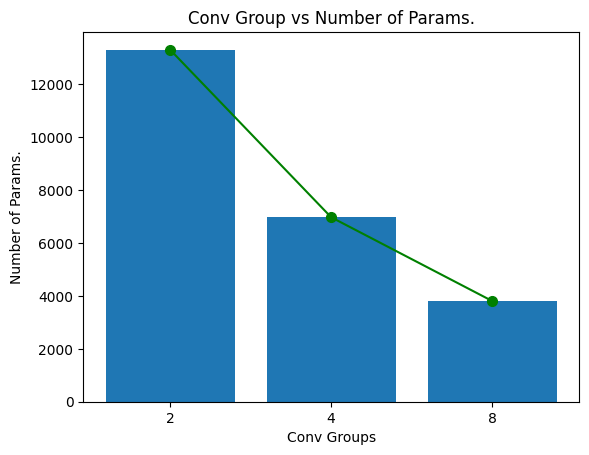

In [38]:
x = [str(exp["groups"]) for exp in [exp_2_1, exp_2_2, exp_2_3]]
y = [exp["n_params"] for exp in [exp_2_1, exp_2_2, exp_2_3]]

plt.bar(x, y)
plt.plot(x, y, color='g', marker='o', markersize=7)
#plt.ylim(18, 20)
plt.xlabel("Conv Groups")
plt.ylabel("Number of Params.")
plt.title("Conv Group vs Number of Params.")

Text(0.5, 1.0, 'Conv Groups vs Flops')

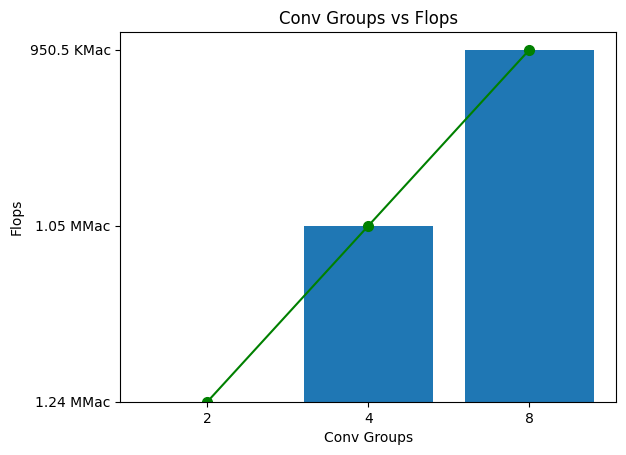

In [39]:
x = [str(exp["groups"]) for exp in [exp_2_1, exp_2_2, exp_2_3]]
y = [exp["flops"] for exp in [exp_2_1, exp_2_2, exp_2_3]]

plt.bar(x, y)
plt.plot(x, y, color='g', marker='o', markersize=7)
#plt.ylim(18, 20)
plt.xlabel("Conv Groups")
plt.ylabel("Flops")
plt.title("Conv Groups vs Flops")